## Import Data ##

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pillow_avif
import cv2
import seaborn_image as isns
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import random
from scipy.stats import *
import time
import warnings
import os
from pathlib import Path

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [139]:
def extract_frames_from_nested_dirs():
    base_dir = os.getcwd()
    input_base = os.path.join(base_dir, "files")
    output_base = os.path.join(base_dir, "Data")
    video_extensions = {".mp4", ".avi", ".mov", ".mkv", ".flv", ".wmv"}

    for subdir in os.listdir(input_base):
        subdir_path = os.path.join(input_base, subdir)

        if not os.path.isdir(subdir_path):
            continue

        for video_file in os.listdir(subdir_path):
            if Path(video_file).suffix.lower() not in video_extensions:
                continue

            video_path = os.path.join(subdir_path, video_file)
            video_stem = Path(video_file).stem

            video_output_dir = os.path.join(output_base, subdir, video_stem)
            os.makedirs(video_output_dir, exist_ok=True)

            cam = cv2.VideoCapture(video_path)
            currentframe = 0

            while True:
                ret, frame = cam.read()
                if not ret:
                    break

                frame_filename = os.path.join(video_output_dir, f"frame{currentframe}.jpg")
                cv2.imwrite(frame_filename, frame)
                currentframe += 1

            cam.release()
            cv2.destroyAllWindows()
            print(f"Extracted {currentframe} frames from {video_file} in '{subdir}'.")

extract_frames_from_nested_dirs()

Extracted 250 frames from 4.mp4 in 'non_aggressive'.
Extracted 150 frames from 5.mp4 in 'non_aggressive'.
Extracted 330 frames from 1.mp4 in 'non_aggressive'.
Extracted 96 frames from 0.mp4 in 'non_aggressive'.
Extracted 78 frames from 2.mp4 in 'non_aggressive'.
Extracted 54 frames from 3.mp4 in 'non_aggressive'.
Extracted 1287 frames from 4.mp4 in 'aggressive'.
Extracted 365 frames from 1.mp4 in 'aggressive'.
Extracted 741 frames from 0.mp4 in 'aggressive'.
Extracted 169 frames from 2.mp4 in 'aggressive'.
Extracted 1111 frames from 3.mp4 in 'aggressive'.


In [178]:
image_path = []
labels = []

dir_path = os.getcwd()
data_path = os.path.join(dir_path, "Data")

for i in os.listdir(data_path):
    i_path = os.path.join(data_path, i)
    if not os.path.isdir(i_path) or i.startswith("."):
        continue

    for label in os.listdir(i_path):
        label_path = os.path.join(i_path, label)
        if not os.path.isdir(label_path) or label.startswith("."):
            continue

        for image in os.listdir(label_path):
            if image.startswith("."):
                continue
            image_path.append(os.path.join(label_path, image))
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

image_path          labels
0     /Users/jay/Jupyter Projects/Violence/Data/non_...  non_aggressive
1     /Users/jay/Jupyter Projects/Violence/Data/non_...  non_aggressive
2     /Users/jay/Jupyter Projects/Violence/Data/non_...  non_aggressive
3     /Users/jay/Jupyter Projects/Violence/Data/non_...  non_aggressive
4     /Users/jay/Jupyter Projects/Violence/Data/non_...  non_aggressive
...                                                 ...             ...
4626  /Users/jay/Jupyter Projects/Violence/Data/aggr...      aggressive
4627  /Users/jay/Jupyter Projects/Violence/Data/aggr...      aggressive
4628  /Users/jay/Jupyter Projects/Violence/Data/aggr...      aggressive
4629  /Users/jay/Jupyter Projects/Violence/Data/aggr...      aggressive
4630  /Users/jay/Jupyter Projects/Violence/Data/aggr...      aggressive

[4631 rows x 2 columns]

## Statistical Modeling ##

Shape:  (4631, 2)

Counts:
 labels
aggressive        3673
non_aggressive     958
Name: count, dtype: int64



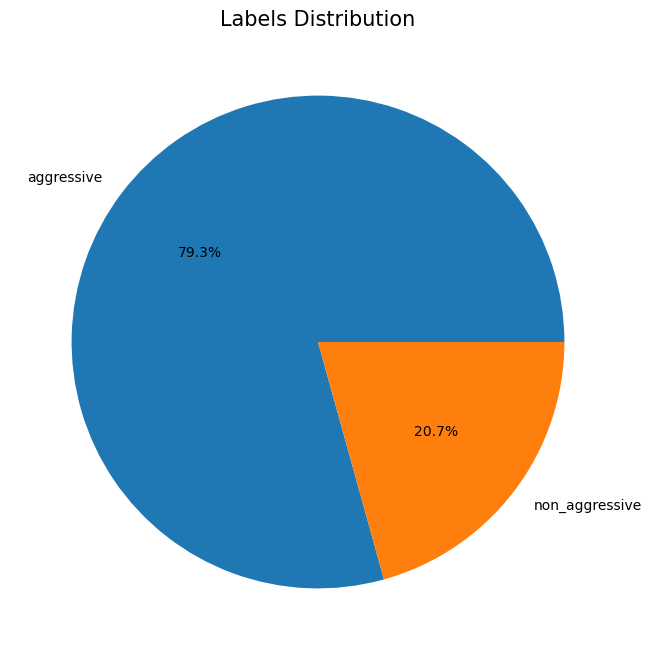

In [180]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

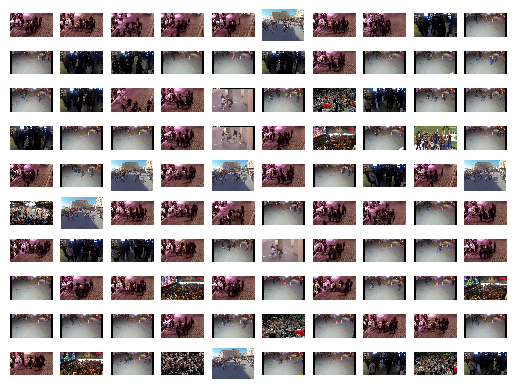

In [185]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()


Description for Image 1:

No. of Obs. : 921600
Min. Value : 0
Max. Value : 255
Mean : 65.562900390625
Variance : 2955.1747123502264
Skewness : 0.9305452048983883

Description for Image 2:

No. of Obs. : 921600
Min. Value : 0
Max. Value : 255
Mean : 65.04333333333334
Variance : 2892.6082378995634
Skewness : 0.9446360637856567

Description for Image 3:

No. of Obs. : 921600
Min. Value : 0
Max. Value : 255
Mean : 62.88978298611111
Variance : 3023.990284925003
Skewness : 0.94239600218806

Description for Image 4:

No. of Obs. : 921600
Min. Value : 0
Max. Value : 255
Mean : 63.283772786458336
Variance : 2990.9789586599168
Skewness : 0.9570696973681845

Description for Image 5:

No. of Obs. : 921600
Min. Value : 0
Max. Value : 255
Mean : 63.53977105034722
Variance : 2949.307174022207
Skewness : 0.9589233591675561


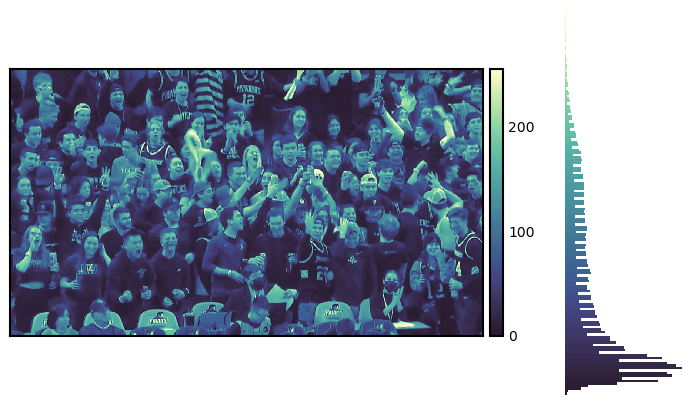

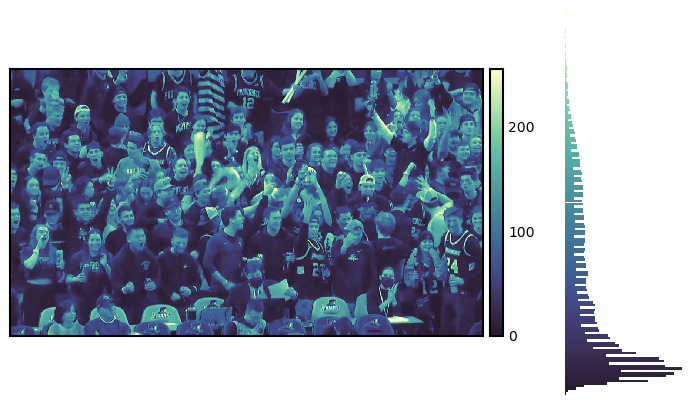

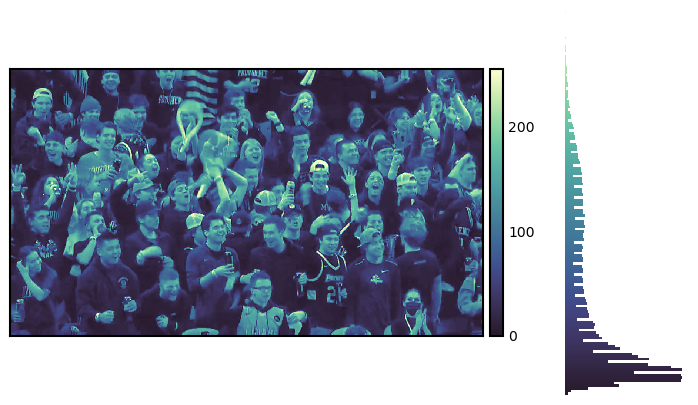

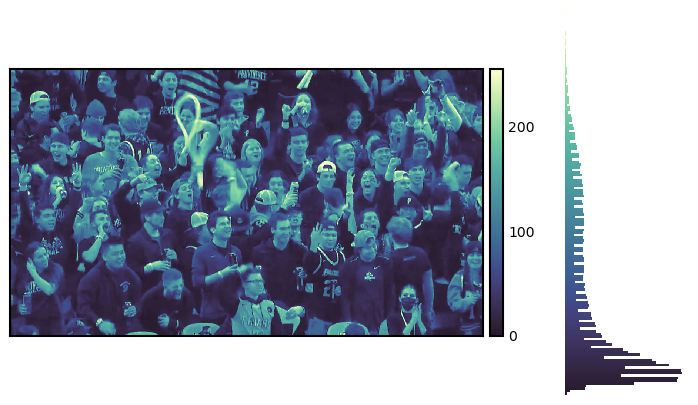

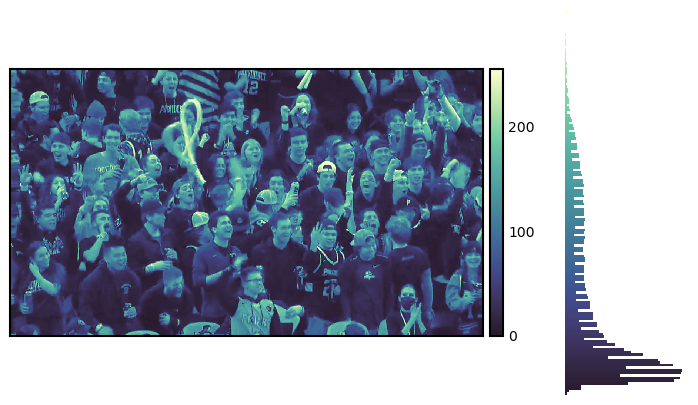

In [186]:
for i in range(5):
    pol = plt.imread(df.iloc[0+i, 0])[:, :, 0]
    print(f"\nDescription for Image {i+1}:\n")
    print("="*50)
    f = isns.imghist(pol, describe=True)

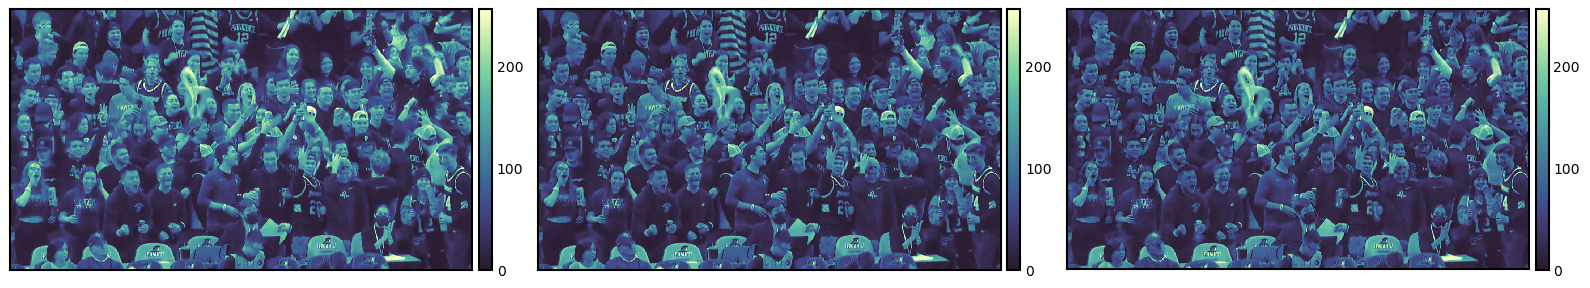

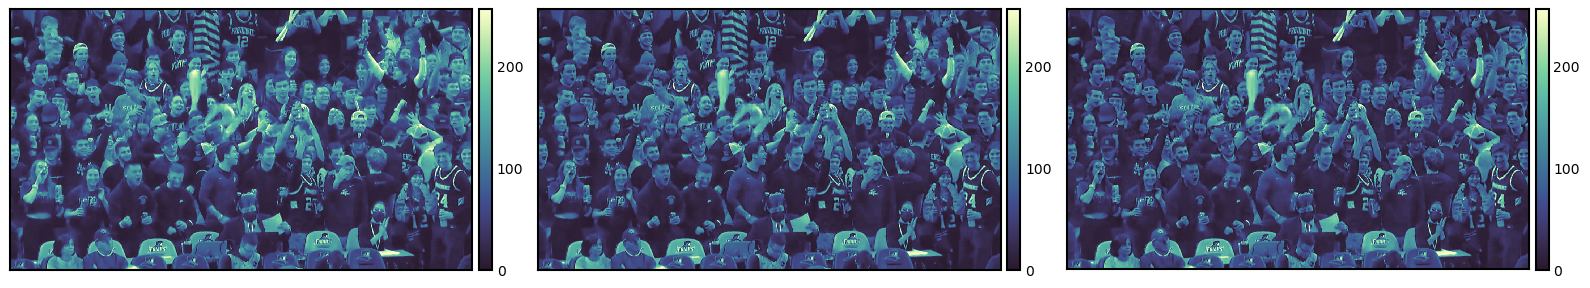

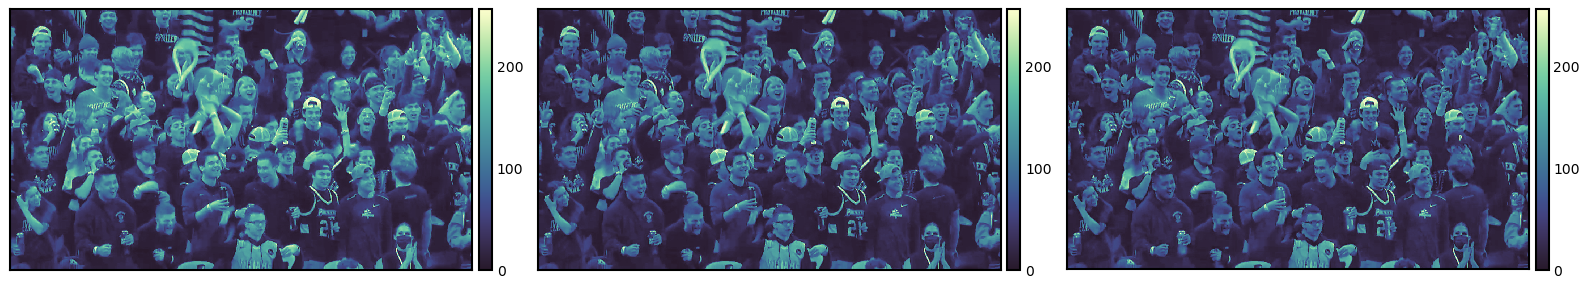

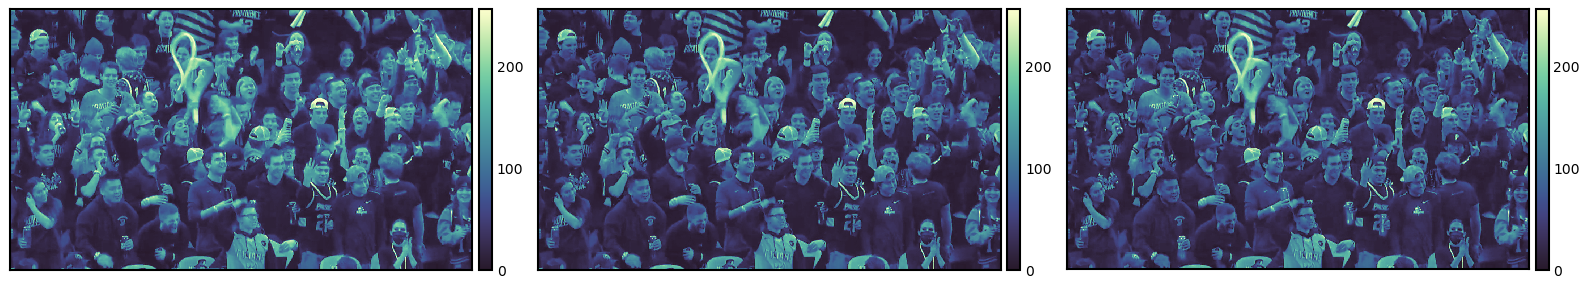

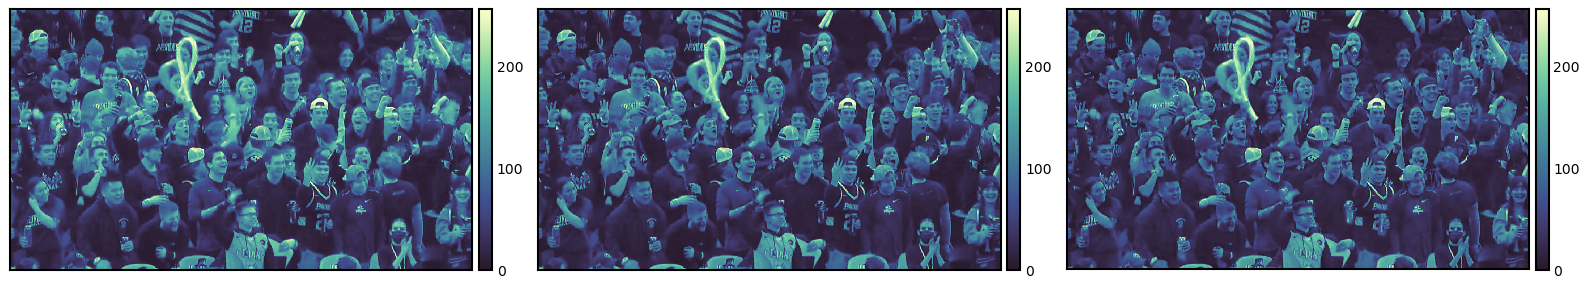

In [187]:
for i in range(5):
    ims = plt.imread(df.iloc[0+i, 0])
    grid = isns.ImageGrid(ims)

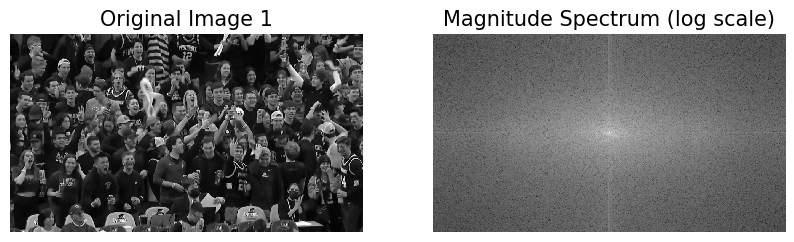

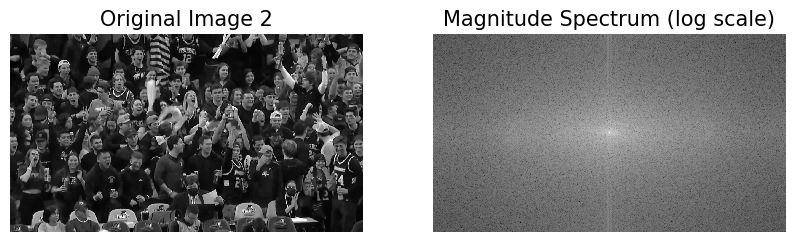

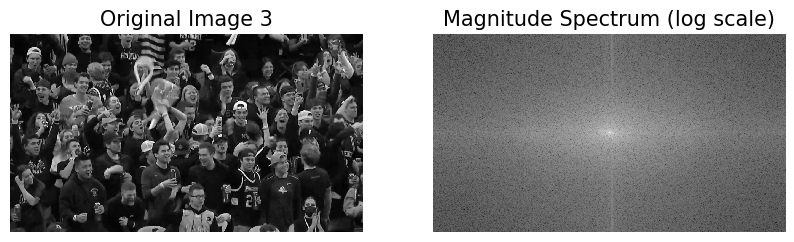

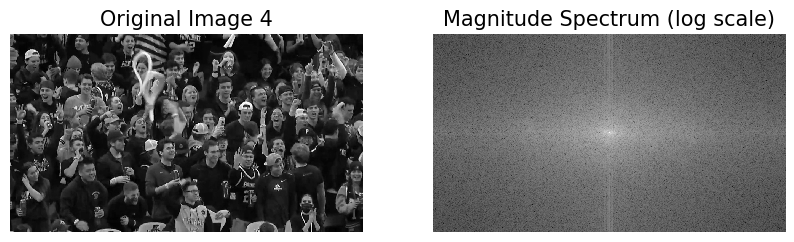

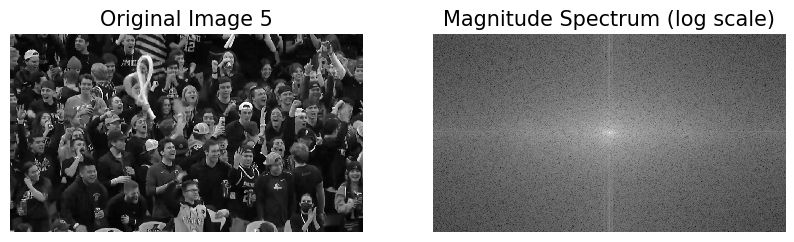

In [188]:
for i in range(5):
    img_data = plt.imread(df.iloc[0+i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(img_data)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="gray")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log, cmap="gray")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

Number of clusters in image 1: 5
Number of clusters in image 2: 3
Number of clusters in image 3: 5
Number of clusters in image 4: 6
Number of clusters in image 5: 6


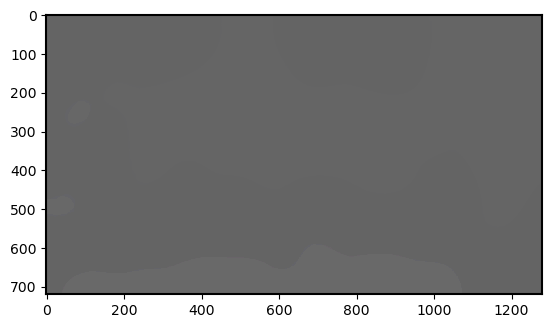

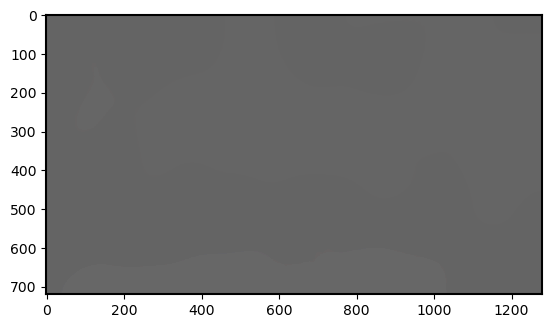

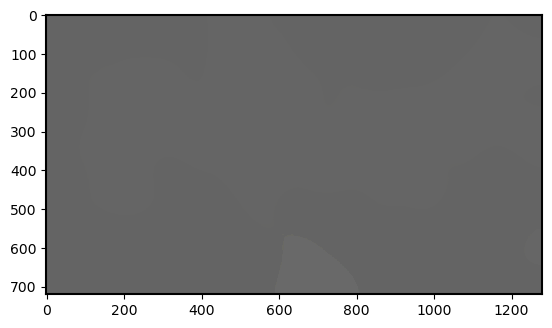

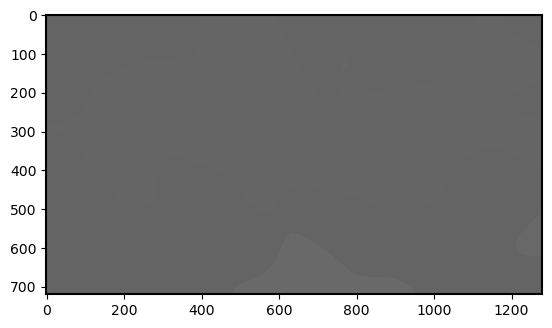

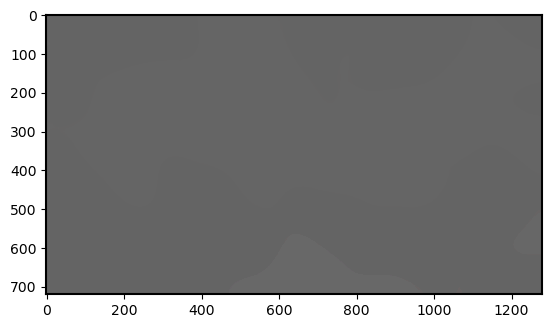

In [189]:
from scipy import ndimage

for i in range(5):
    plt.figure()
    
    im = Image.open(df.iloc[i, 0])
    im2 = ndimage.gaussian_filter(im, sigma=np.std(np.array(im)))
    plt.imshow(im2);
    mask = im2 > im2.mean()
    label_im, nb_labels = ndimage.label(mask)
    print(f"Number of clusters in image {i+1}: {nb_labels}")
    brightness = 100
    plt.imshow(label_im+brightness);
    i += 1

## Training Model ##

In [191]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(3242, 2)
(694, 2)
(695, 2)


In [193]:
class NumpyOperations:
    def __init__(self, augment_probability=0.15, apply_LinearAl_ops = False):
        self.augment_probability = augment_probability
        self.apply_LinearAl_ops = apply_LinearAl_ops

    def __call__(self, image):
        image_np = np.array(image)
        
        image_np = image_np / 255
        
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np, k=3)
            
        if random.random() < self.augment_probability:
            image_np = np.flip(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.fliplr(image_np)
                        
        if random.random() < self.augment_probability:
            image_np = np.flipud(image_np)
                        
        if random.random() < self.augment_probability:
            brightness = random.randrange(10, 100)
            image_np = image_np.astype(np.uint16) + brightness
        
        if self.apply_LinearAl_ops:
            image_np = np.transpose(image_np, (1, 0, 2))
        
        image_np = np.clip(image_np, 0, 255)
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
        
        return image_pil

In [196]:
le = LabelEncoder()
le.fit(df["labels"])
crop_size = (224, 224)

transform = transforms.Compose([
    transforms.RandomCrop(size=crop_size),
    transforms.Resize([128, 128]),
    NumpyOperations(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ConvertImageDtype(torch.float)
])

In [197]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment_probability=0.15):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.augment_probability = augment_probability
        self.operation_transform = NumpyOperations(augment_probability, apply_LinearAl_ops=False) #Can toggle the linal ops
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)
        self.original_len = len(dataframe)

    def __len__(self):
        return 2 * self.original_len

    def __getitem__(self, idx):
        is_augmented = idx >= self.original_len
        real_idx = idx % self.original_len

        img_path = self.dataframe.iloc[real_idx, 0]
        label = self.labels[real_idx]
        image = Image.open(img_path).convert("RGB")

        if is_augmented:
            image = self.operation_transform(image)

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [198]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

print("New Train Dataset Size:", len(train_dataset))
print("New Validation Dataset Size:", len(val_dataset))
print("New Test Dataset Size:", len(test_dataset))

New Train Dataset Size: 6484
New Validation Dataset Size: 1388
New Test Dataset Size: 1390


In [199]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [200]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [201]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [202]:
model = Net().to(device)

In [203]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            258
Total params: 4,287,938
Trainable params: 4,287,938
Non-trainable params: 0

In [204]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [205]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/10 
    Training Loss: 0.1128 
    Training Accuracy: 89.9907 
    Validation Loss: 0.0161 
    Validation Accuracy: 93.2277
Epoch no. 2/10 
    Training Loss: 0.0853 
    Training Accuracy: 92.3041 
    Validation Loss: 0.0174 
    Validation Accuracy: 92.4352
Epoch no. 3/10 
    Training Loss: 0.0694 
    Training Accuracy: 93.9543 
    Validation Loss: 0.0142 
    Validation Accuracy: 93.732
Epoch no. 4/10 
    Training Loss: 0.0674 
    Training Accuracy: 93.7847 
    Validation Loss: 0.0177 
    Validation Accuracy: 92.0749
Epoch no. 5/10 
    Training Loss: 0.0698 
    Training Accuracy: 93.8155 
    Validation Loss: 0.0154 
    Validation Accuracy: 93.804
Epoch no. 6/10 
    Training Loss: 0.0643 
    Training Accuracy: 94.1394 
    Validation Loss: 0.0149 
    Validation Accuracy: 93.3718
Epoch no. 7/10 
    Training Loss: 0.0635 
    Training Accuracy: 94.232 
    Validation Loss: 0.0143 
    Validation Accuracy: 93.9481
Epoch no. 8/10 
    Training Loss: 0.0631 
 

In [206]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 95.6115 
Loss: 0.0111


## Post-Training Analysis ##

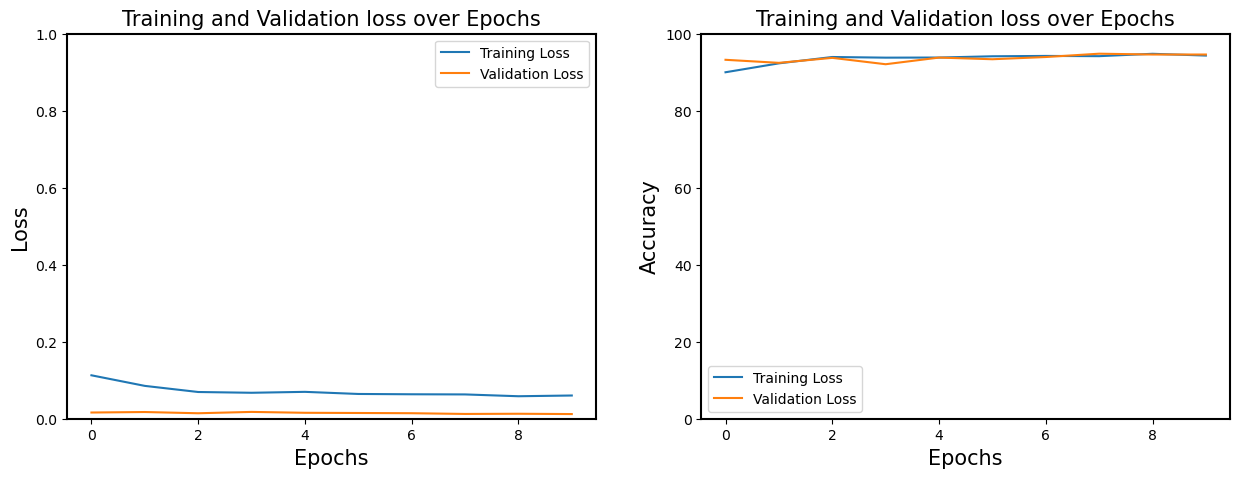

In [207]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [208]:
torch.save(model.state_dict(), "model.pth")

In [221]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

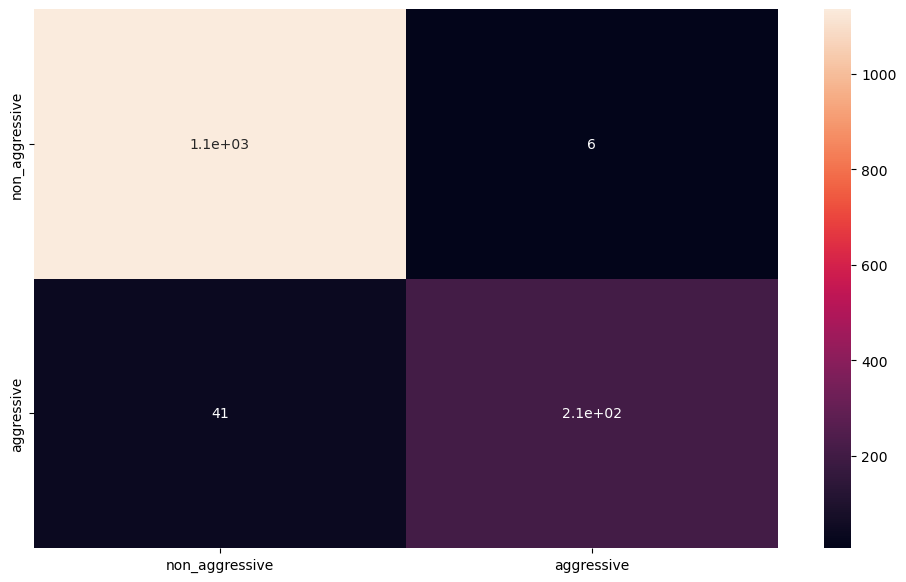

In [222]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        output = loaded_model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = df["labels"].unique()

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True);

In [223]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['aggressive']


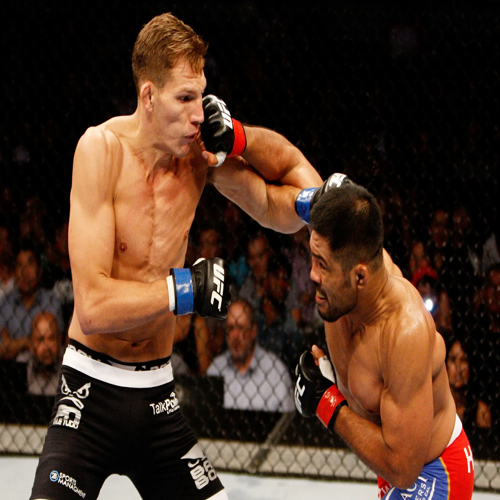

In [251]:
path1 = f"{dir_path}/Fight.webp"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([500, 500])

['non_aggressive']


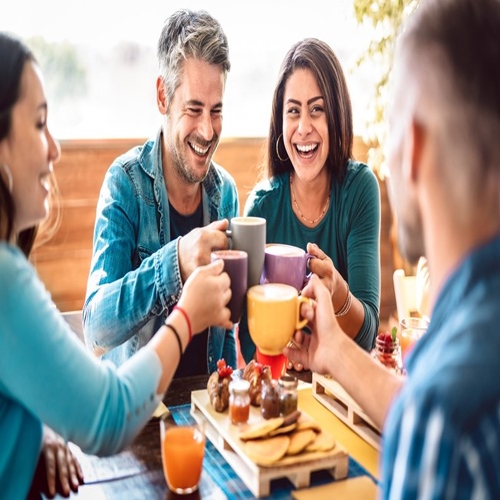

In [227]:
path2 = f"{dir_path}/Friendly.jpg"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([500, 500])